# Отчёт о выполнении практического задания 4
## Выполнил: студент 317 группы Попов Дмитрий

Выполнено: все пункты задания, включая бонус (итого 18 баллов). Функции в стиле ООП выделены в отдельный .py-файл с соответствующим суффиксом. В нём реализованы и используются классы F2qElement и F2qPolynomial, представляющие собой элементы поля **GF(2^q)** и кольца многочленов **GF(2^q)[X]** соответственно. Функции типа "операция сложить/умножить/разделить" в этом файле вызывают перегруженные операторы в самих классах. В задании не было чётко прописано, что понимается под этим пунктом, но автор надеется, что сделал всё так, как ожидалось. Демонстрация работы бонусной части идут в конце отчёта.

Модули gf.py и bch.py были протестированы **пофиксенным** тестом, прилагавшимся к заданию. В тесте изменено:
1. Вызов функции sum() - добавлен аргумент keepdims=True, потому что судя по выданным тестам, ожидается, что функция не будет сжимать итоговый массив (можно поставить False, чтобы поведение соответствовало аналогичной функции в библиотеке Numpy).
2. Тест алгоритма Евклида: судя по количествам элементам в ожидающихся массивах, max_deg должен быть равен 2, а не 3 (иначе алгоритм не делит до конца). Кроме того, автор убрал лидирующие нули, потому что функции он реализовывать с триммингом.

Пофиксенный файл с тестами прилагается в архиве. Проверяющий может убедиться, что изменения были внесены только выше описанные.

In [2]:
import numpy as np
from bch import BCH

%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Эксперимент 1 (пункт задания 1.5)

In [3]:
print('{0}\t{1}\t{2}'.format('n', 't', 'can fix errors'))
for n_p in range(3, 5):
    n = (1 << n_p) - 1
    for t in range(1, 4):
        b = BCH(n, t)
        if b.dist() > 2 * t + 1:
            print('{0:d}\t{1:d}\t{2:d}'.format(n, t, b.dist()//2))

n	t	can fix errors
7	2	3


Искомый код найден. Построен он для исправления 2 ошибок, но на деле может исправлять до 3 (и обнаруживать 4). Есть и другие примеры:

In [4]:
print('{0}\t{1}\t{2}'.format('n', 't', 'can fix errors'))
n = 7
t = 2

b = BCH(n, t)
if b.dist() > 2 * t + 1:
    print('{0:d}\t{1:d}\t{2:d}'.format(n, t, b.dist()//2))

n = 15
t = 4

b = BCH(n, t)
if b.dist() > 2 * t + 1:
    print('{0:d}\t{1:d}\t{2:d}'.format(n, t, b.dist()//2))
    
n = 31
t = 4

b = BCH(n, t)
if b.dist() > 2 * t + 1:
    print('{0:d}\t{1:d}\t{2:d}'.format(n, t, b.dist()//2))

n	t	can fix errors
7	2	3
15	4	7
31	4	5


## Эксперимент 2 (пункт задания 2.2)

In [43]:
def stat_test(coder, test_num, max_errors):
    correct = np.zeros(max_errors + 1)
    wrong = np.zeros(max_errors + 1)
    rejected = np.zeros(max_errors + 1)

    for n_errors in range(max_errors + 1):
        u = np.random.randint(0, 2, [test_num, coder.k])
        v = coder.encode(u)
        w = v
        for row in w:
            errors = np.random.choice(row.shape[0], n_errors, False)
            row[errors] ^= 1
            
        w_1 = coder.decode(w)
        u_1 = w_1[:, :coder.k]

        for i in range(u_1.shape[0]):
            if u_1[i][0] < 0:
                rejected[n_errors] += 1
            elif (u_1[i] ^ u[i]).sum() == 0:
                correct[n_errors] += 1
            else:
                wrong[n_errors] += 1
                
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    ax.bar(np.arange(0, correct.shape[0]), correct, bottom=0, label='Исправление', color='g')
    ax.bar(np.arange(0, rejected.shape[0]), rejected, bottom=correct, label='Отказ', color='y')
    ax.bar(np.arange(0, wrong.shape[0]), wrong, bottom=correct + rejected, label='Ошибка', color='r')    
    ax.legend(loc='upper right')
    ax.set_xlabel('Ошибок из-за помех', fontsize = 20)
    ax.set_ylabel('Испытаний', fontsize = 20)

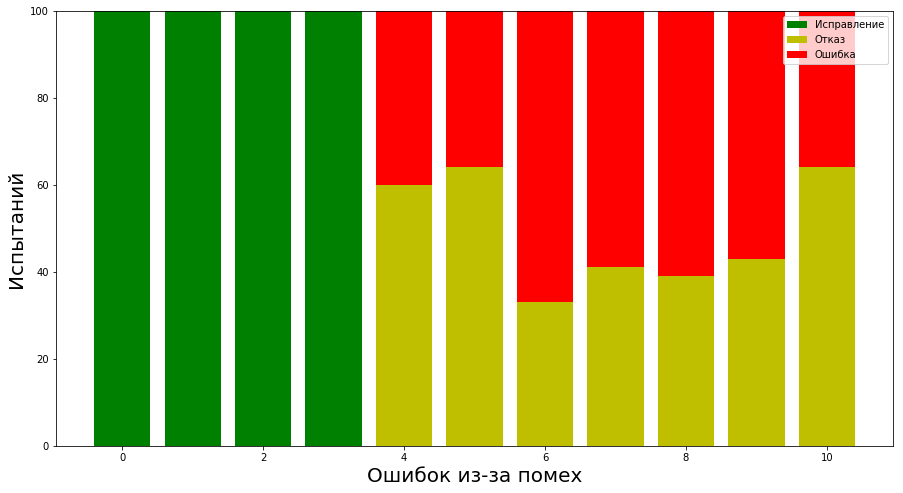

In [44]:
stat_test(BCH(15, 3), 100, 10)

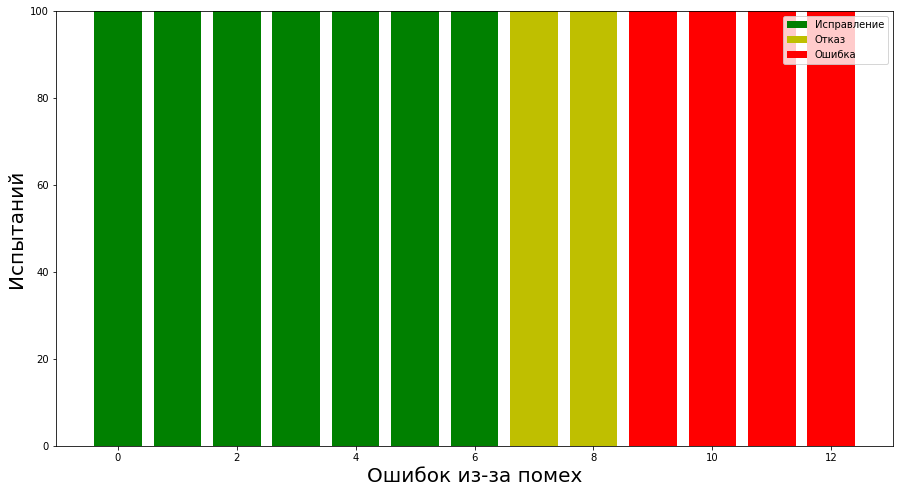

In [45]:
stat_test(BCH(15, 6), 100, 12)

Как мы можем видеть, коды действительно исправляют столько ошибок, сколько должны по построению. После этого момента некоторое количество ошибок код отказывается исправлять, после чего искажённые кодовые слова начинают попадать в окрестности неверных кодовых слов и алгоритм начинает неверно восстанавливать сообщения.

## Эксперимент 3 (пункт задания 2.3)

Сравним скорость работы декодеров PGZ и основанного на расширенном алгоритме Евклида. Априорно ожидается, что PGZ будет работать медленнее из-за решения СЛАУ N раз подряд - значительно больше операций, чем в алгоритме Евклида.

In [47]:
from timeit import timeit

In [86]:
n_powers = range(3, 10)
pgz = []
euclid = []
ns = [(1 << n_p) - 1 for n_p in n_powers]

In [87]:
for n_p in n_powers:
    coder = BCH((1 << n_p) - 1, (1 << (n_p - 2)) * 3)
    msg = coder.encode(np.random.randint(0, 2, [1, coder.k]))
    errors = np.random.choice(coder.n, size=n_p, replace=False)
    msg[0, errors] ^= 1
    
    pgz.append(timeit(lambda: coder.decode(msg, method='pgz'), number=1))
    euclid.append(timeit(lambda: coder.decode(msg, method='euclid'), number=1))

Text(0, 0.5, 'Время работы (с)')

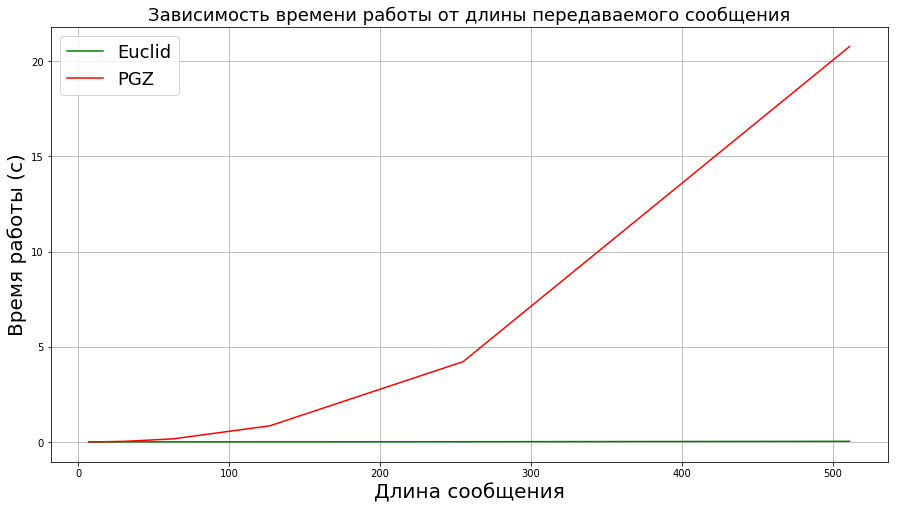

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(ns, euclid, label='Euclid', color='g')
ax.plot(ns, pgz, label='PGZ', color='r')
ax.legend(fontsize=18)
ax.grid(True)
ax.set_title('Зависимость времени работы от длины передаваемого сообщения', fontsize=18)
ax.set_xlabel('Длина сообщения', fontsize = 20)
ax.set_ylabel('Время работы (с)', fontsize = 20)

Text(0, 0.5, 'Время работы (с)')

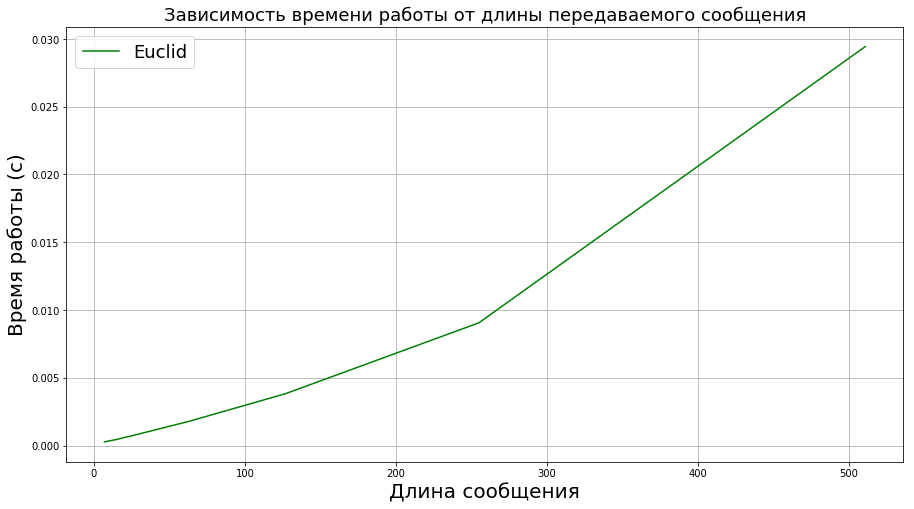

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(ns, euclid, label='Euclid', color='g')
ax.legend(fontsize=18)
ax.grid(True)
ax.set_title('Зависимость времени работы от длины передаваемого сообщения', fontsize=18)
ax.set_xlabel('Длина сообщения', fontsize = 20)
ax.set_ylabel('Время работы (с)', fontsize = 20)

И действительно, эксперимент показывает, что декодер PGZ значительно дольше работает, чем расширенный алгоритм Евклида. Однако, рассмотренный диапазон значений длины не позволяет продемонстрировать нелинейную разницу, на исследованных выглядит так, будто PGZ просто в несколько сотен раз медленнее на любом входе.

## Демонстрация работы классов и функций в ООП-стиле (Бонус)

In [92]:
import gf_oop

Будем работать в конечном поле **GF(2)[x]/(x^3+x+1)**. Сначала создадим матрицу степеней элементов, это необходимо для инстанцирования любых объектов в этом поле (именно матрица задаёт, в каком поле мы работаем).

In [93]:
pm = gf_oop.gen_pow_matrix(11)

In [94]:
pm

array([[7, 2],
       [1, 4],
       [3, 3],
       [2, 6],
       [6, 7],
       [4, 5],
       [5, 1]])

Результат работы совпадает с теоретическим знанием.

Автор реализовал возможность инстанцирования элементов поля как по численному значению, так и по степенному:

In [96]:
elem1 = gf_oop.F2qElement(6, 'num', pm)
elem2 = gf_oop.F2qElement(2, 'pow', pm)

In [98]:
elem1.num, elem1.pow

(6, 4)

In [99]:
elem2.num, elem2.pow

(4, 2)

Всё так, как и ожидается.

Элементы конечных полей можно складывать, умножать, делить:

In [102]:
(elem1 + elem2).num, (elem1 + elem2).pow

(2, 1)

In [106]:
(elem1 * elem2).num, (elem1 * elem2).pow

(5, 6)

In [107]:
(elem1 / elem2).num, (elem1 / elem2).pow

(4, 2)

Проверить, что всё работает правильно, можно, используя выведенные степени и таблицу переходов, которую автор вывел чуть выше.

Продемонстрируем такую же работу с многочленами в конструкции **(GF(2)[x]/(x^3+x+1))[X]**. Многочлены допускают уже три способа инстанцирования:

In [110]:
pol1 = gf_oop.F2qPolynomial([elem1, elem2], 'elem', pm)
pol2 = gf_oop.F2qPolynomial([3, 2], 'num', pm)
pol3 = gf_oop.F2qPolynomial([6, 5], 'pow', pm)

In [111]:
[elem.num for elem in pol1.coefs], [elem.pow for elem in pol1.coefs]

([6, 4], [4, 2])

In [112]:
[elem.num for elem in pol2.coefs], [elem.pow for elem in pol2.coefs]

([3, 2], [3, 1])

In [113]:
[elem.num for elem in pol3.coefs], [elem.pow for elem in pol3.coefs]

([5, 7], [6, 5])

In [117]:
pol4 = pol1 + pol2

In [118]:
[elem.num for elem in pol4.coefs], [elem.pow for elem in pol4.coefs]

([5, 6], [6, 4])

In [124]:
pol5 = pol2 * pol3

In [125]:
[elem.num for elem in pol5.coefs], [elem.pow for elem in pol5.coefs]

([4, 3, 5], [2, 3, 6])

Проведя вычисления на бумаге, можно убедиться, что функции реализованы правильно.